In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import math as m
import os
from time import time as tm
from numba import cuda, njit, vectorize
from time import sleep, time
from findhubs import *
from a_star import *
from astro import *
from ConCreate import *

In [12]:
def LoadTime(Log):
    with open(Log,'r') as log:
        contents = log.read().split('\n')
        firstline =  contents[0].split()
        lastcontents = contents[-2] if contents[-1] == '' else contents[-1]
        del contents
        data = lastcontents.split()
        StartTime = datetime.datetime.strptime(firstline[0]+' '+firstline[1],'%Y-%m-%d %H:%M:%S')
        time = datetime.datetime.strptime(data[0]+' '+data[1],'%Y-%m-%d %H:%M:%S') 
        t = int((time - StartTime).total_seconds())
    return StartTime,time,t

def AlToTH(alpha,R):
    return np.degrees(np.pi/2 -  np.arccos(np.sin(alpha)*R/6378137) - alpha )

def WriteTime(Log,time):
    with open(Log,'a') as log:
        log.write(str(time) + '\n')
        
def GetSSP(cartSat,t):
    azim = np.arctan2(cartSat[:,1],cartSat[:,0])
    elev = np.arctan2(cartSat[:,2],np.sqrt((cartSat[:,:2]**2).sum(1)))
    R0 = 6378137
    av = 7.2921158553e-5
    z0ecf = R0 * np.sin(elev)
    x0ecf = R0 * np.cos(elev) * np.cos(azim)
    y0ecf = R0 * np.cos(elev) * np.sin(azim)
    ang = av*t
    R0eci = (astro.R3(ang).dot(np.array([x0ecf, y0ecf, z0ecf]))).T
    Lons = np.degrees(np.arctan2(R0eci[:,1],R0eci[:,0]))
    Lats = np.degrees(np.arctan2(R0eci[:,2],np.sqrt((R0eci[:,:2]**2).sum(1))))
    return np.vstack((Lats,Lons)).T


@cuda.jit
def GetTRF(ssp, theta,PopCount, TR):
    pos = cuda.grid(1)
    if pos < ssp.shape[0]:
        N = 1.2 if ssp[pos,0] <85.0 else 1
        rows,columns = PopCount.shape
        step = 180/rows
        cl = ssp[pos,0]+theta[pos]/8
        dl = m.degrees(m.acos((m.cos(m.radians(theta[pos]))-m.sin(m.radians(cl))**2)/m.cos(m.radians(cl))**2))
        dl = 180 if dl!=dl else dl
        
        LonStart,LonStop = ssp[pos,1]- dl*N, ssp[pos,1]+ dl*N
        LatStart,LatStop = ssp[pos,0]+ theta[pos]*N, ssp[pos,0]- theta[pos]*N
        
        RowStart,ColumnStart = LatLonToindex(LatStart,LonStart,step)
        upEdge = 0.038148148148148146*rows   
        RowStart = int(upEdge if RowStart < upEdge else RowStart)

        RowStop, ColumnStop = LatLonToindex(LatStop,LonStop,step)
        downEdge = 0.8110185185185185*rows
        RowStop = int(downEdge if RowStop  > downEdge else RowStop)
        

        summ = 0
        cx =  m.radians(ssp[pos,0])
        cy = m.radians(ssp[pos,1])
        for row in range(RowStart,RowStop):
            for col in range(ColumnStart,ColumnStop):
                value = PopCount[row,col]
                lat,lon = indexToLatLon(row, col,step)
                wLat, wLon = m.radians(lat), m.radians(lon)
                ang = m.acos(m.sin(cx)*m.sin(wLat)+ m.cos(cx)*m.cos(wLat)*m.cos(m.fabs(cy-wLon)))
                if m.degrees(ang) <= theta[pos]:
                    summ = summ + value
        TR[pos] = summ
        
@njit
def indexToLatLon(row, col,step):
    lat = 90 - row*step - step/2
    lon = -180 + col*step + step/2
    return lat, lon

@njit
def LatLonToindex(lat, lon,step):
    lat = 90 - lat
    lon = 180 + lon
    row = lat//step
    col = lon//step
    return int(row),int(col)

def GetTraffic(ssp,Thetta,newMap,Kerns):
    TR = np.zeros(ssp.shape[0],dtype=np.float64)
    threadsperblock = Kerns
    blockspergrid = (ssp.shape[0] + (threadsperblock - 1)) // threadsperblock
    GetTRF[blockspergrid, threadsperblock](ssp, Thetta,newMap, TR)
    return TR

In [69]:
ConstParam = pd.read_excel(os.path.join('inputs', 'Constellation.xlsx'))
CP = ConstellationParameters(ConstParam['Satellites'].to_numpy(),ConstParam['Planes'].to_numpy(),
                             np.radians(ConstParam['Inclination'].to_numpy()),ConstParam['Altitude'].to_numpy(),
                             ConstParam['Raan shift'].to_numpy(),ConstParam['Shift'].to_numpy())
gs = pd.read_excel(os.path.join('inputs', 'Stations.xlsx'))
GS = gs[['LAT','LON','MaxConnections']].to_numpy()

alpha = np.radians(56)
HubsNumber = 3                                        # Number of Hub satellites to find  closest path to
timestep = datetime.timedelta(seconds=1)               # Simulation time step
SimulationTime = 1

StartTime,time,t = LoadTime('TimeLog.txt')
hour = time.hour
Map = np.load(os.path.join('maps',f'TrafGrid{time.hour}.npz'))['UTC']
Mask = np.load(f'masks/MaskG{time.hour}.npy')
Map[Mask[0],Mask[1]] = 0

Constellation = CreateConstellation(CP)
Params = IniConstellation(CP,Constellation,[])
# cartSat = UpdateConstellation(Params,Constellation,0)
eshs = np.asarray([sat.eshelon for sat in Constellation])
Thetta = np.asarray([AlToTH(alpha,sat.r) for sat in Constellation])


SimulationTime += t - 1
while t <= SimulationTime:
    st = tm()
    print(f'Current time: {t} out of {SimulationTime}')
    if time.hour != hour:
        del Map
        Map = np.load(os.path.join('maps',f'TrafGrid{time.hour}.npz'))['UTC']
        Mask = np.load(f'masks/MaskG{time.hour}.npy')
        Map[Mask[0],Mask[1]] = 0
    
    

    jd = jday (time.year, time.month, time.day, time.hour, time.minute, time.second)
    
    print('Updating constellation and connections')
    cartSat = UpdateConstellation(Params,Constellation,t)
    hubIndexes = findHubs(GS, jd, cartSat, 25)

    SSP = GetSSP(cartSat,t)
    print('Getting the traffic')
    TRF = GetTraffic(SSP,Thetta,Map,320)
    Connections = CreateCM(Constellation,False)

    print('Getting parents')
    Parents = GetParents(Connections,320)
    np.save('Parents.npy',Parents)

    print('Finding the paths')
    Paths,lengthM,lengthNodes = GetPaths(Parents,HubsNumber,cartSat,hubIndexes,eshs)
    print(np.mean(lengthNodes),hubIndexes.size)

    WritePathes(Paths,lengthM,lengthNodes,TRF,os.path.join('outputs','PathsN', f'Paths_{t}.csv'))
    
    print(f'Parhs for time {t} has been saved, it took %.1f s' %(tm()- st))
    time += timestep
    hour = time.hour
    t = int((time - StartTime).total_seconds())
    
#     WriteTime('TimeLog.txt',time)

Current time: 0 out of 0
Updating constellation and connections
Getting the traffic
Getting parents
5 320
Finding the paths
7.655934343434343 464
Parhs for time 0 has been saved, it took 12.3 s


In [40]:
result = pd.read_csv('outputs\PathsN\Paths_4.csv')
print(result['Traffic'].max())
traffic = result[['Traffic']]
result.head(10)

1883.44545157002


,Hub,Length [m],Path,Length [nodes],Traffic,Origin
0,43,2.615151e+06,[43 21 0],3,178.616489,0
1,43,4.587104e+06,[43 21 0 1],4,0.053466,1
2,1364,8.110600e+06,[1364 1385 1407 1429 1451 1473 1495 1517 1539 ...,12,0.000000,2
3,179,4.300956e+06,[179 157 135 113 91 69 47 25 3],9,0.000000,3
4,179,6.272909e+06,[179 157 135 113 91 69 47 25 3 4],10,0.068828,4
5,1543,2.877177e+06,[1543 1542 1564 5],4,17.534264,5
6,1565,4.506305e+05,[1565 6],2,0.000000,6
7,1566,4.872460e+05,[1566 7],2,0.000000,7
8,1567,5.445579e+05,[1567 8],2,0.000000,8
9,30,2.519022e+06,[30 8 9],3,0.073550,9


In [6]:
[sat.globalid for sat in Constellation[0].links.list]

[1, 21, 1581, 22]

In [52]:
result = pd.read_csv('C:\\Users\Harkn\Desktop\BroadbandConst\outputs\PathsN\Paths_9.csv')
print(result['Length [nodes]'].mean())
traffic = result[['Traffic']]
result.head(10)

5.784090909090909


,Hub,Length [nodes],Path,Traffic,Length [m],Origin
0,43,3,[43 21 0],194.597182,2.614613e+06,0
1,43,4,[43 21 0 1],0.053466,4.586566e+06,1
2,1364,12,[1364 1385 1407 1429 1451 1473 1495 1517 1539 ...,0.000000,8.119370e+06,2
3,179,9,[179 157 135 113 91 69 47 25 3],0.000000,4.310185e+06,3
4,179,10,[179 157 135 113 91 69 47 25 3 4],0.068828,6.282138e+06,4
5,136,8,[136 114 92 70 48 26 4 5],18.380316,4.879436e+06,5
6,1565,2,[1565 6],0.000000,4.502673e+05,6
7,1566,2,[1566 7],0.000000,4.862787e+05,7
8,1567,2,[1567 8],0.000000,5.434023e+05,8
9,30,3,[30 8 9],0.073550,2.517867e+06,9


[200]
[ 43  65  87 196 672 694 715 716 737 738 759 760 782]
fig
[ 44  65  64  86 108 130 152 174 196] 9
0.2.0
0.2.21
0.2.20
0.3.20
0.4.20
0.5.20
0.6.20
0.7.20
[44 65 87] 3
0.2.0
0.2.21
[44 22 43] 3
0.2.0
0.1.0
[44 65] 2
0.2.0


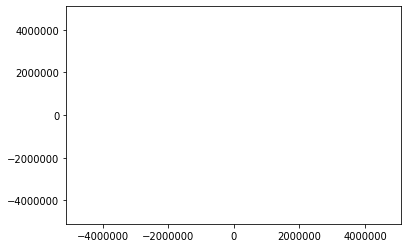

In [30]:
from PIL import Image
from mpl_toolkits.mplot3d import Axes3D

import imageio    
images = []


gs = pd.read_excel(os.path.join('inputs', 'Stations.xlsx'))
GS = gs[['LAT','LON','MaxConnections']].to_numpy()
with open('C:\\Users\Harkn\Desktop\intercom\TimeLog.txt','r') as log:
    contents = log.read().split('\n')[:-1]
    
times = []
for line in contents:
    times.append(datetime.datetime.strptime(line,'%Y-%m-%d %H:%M:%S'))
t = len(times)-1
time = times[t]
jd = jday (time.year, time.month, time.day, time.hour, time.minute, time.second)
N = 44
NN = 10
satEsh = Constellation[N].eshelon
Parents = np.load('Parents.npy')
Constellation = CreateConstellation(CP)
Sats300km = slice(0,np.sum(CP.planes[:3]*CP.sats[:3]))
Sats1000km = slice(np.sum(CP.planes[3:]*CP.sats[3:]),Constellation.size)
eshs = np.asarray([sat.eshelon for sat in Constellation])

Params = IniConstellation(CP,Constellation,[])
cartSat = UpdateConstellation(Params,Constellation,t)    

hubIndexes = findHubs(GS, jd, cartSat, 25)
HubC = cartSat[hubIndexes]
satC = cartSat[N]
x,y,z = satC[0],satC[1],satC[2]
eshInd = eshs[hubIndexes]
inEshC = HubC[eshInd==satEsh]
step = np.radians(5)
section = np.radians(20)
Azumut = np.arctan2(HubC[:,1],HubC[:,0])
Zenith = np.arctan2(np.sqrt((HubC**2).sum(1)),HubC[:,2])

SatZenith = np.arctan2(np.sqrt(x**2+y**2),z)
SatAzumut = np.arctan2(y,x)
closest = np.argsort(np.sqrt(((HubC - satC)**2).sum(1)))
closestInEsh = np.argsort(np.sqrt((inEshC - satC)**2).sum(1))[0]
finals = np.array([closestInEsh])

while len(finals)<NN:
    print(finals)
    arr1 = np.where(np.abs(Zenith - SatZenith)<section)[0]
    arr2 = np.where(np.abs(Azumut - SatAzumut)<section)[0]
    finals = np.append(finals,np.array( list(set(arr1)&set(arr2)&set(closest))))
    finals = np.unique(finals)
    section += step

ClosestHubs = hubIndexes[finals]
print(ClosestHubs)
paths = [findPath(Parents,N ,hub)[::-1] for hub in ClosestHubs]
paths.sort(key=len)
paths = paths[:4][::-1]
shortest = paths[-1]

print('fig')    

for path in paths:
    print(path, len(path))
#     ax.scatter(satE.x,satE.y,satE.z ,c='y', s = 20)

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    plt.axis('off')
    R = 6378137
    deg = np.pi/180
    Ngs = GS.shape[0] 
    for i in range(Ngs):
        z0ecf = R * np.sin(GS[i][0]*deg)
        x0ecf = R * np.cos(GS[i][0]*deg) * np.cos(GS[i][1]*deg)
        y0ecf = R * np.cos(GS[i][0]*deg) * np.sin(GS[i][1]*deg)

        #convert to ECI, then repmat
        x,y,z = R3(-gstime(jd)).dot(np.array([x0ecf, y0ecf, z0ecf]))
        ax.scatter(x,y,z ,c='purple', s = 2)

    ax.scatter(cartSat[:,0],cartSat[:,1],cartSat[:,2] ,c='orange', alpha = 0.5,s = 2)
    satO = Constellation[path][0]
    satE = Constellation[path][-1]
    ax.scatter(satO.x,satO.y,satO.z ,c='b', s = 10)
    ax.scatter(satE.x,satE.y,satE.z ,c='r', s = 10)

    #         for sat in Constellation[Path][1:-1]:
    #             ax.scatter(sat.x,sat.y,sat.z ,c='g', s = 10)

    Nd=35
    stride=2
    u = np.linspace(0, 2 * np.pi, Nd)
    v = np.linspace(0, np.pi, Nd)
    x = R*np.outer(np.cos(u), np.sin(v))
    y = R*np.outer(np.sin(u), np.sin(v))
    z = R*np.outer(np.ones(np.size(u)), np.cos(v))
    # ax.plot_surface(x, y, z, linewidth=0.0, cstride=stride, rstride=stride,color = 'white')
    ax.plot_wireframe(x, y, z, linewidth=0.5, cstride=stride, rstride=stride,color = 'k')


    linkNodes = cartSat[path]
    for n in range(len(linkNodes)-1):
        print(Constellation[path][n].id)
        satM = linkNodes[n]
        satS = linkNodes[n+1]
        ax.scatter(satM[0],satM[1],satM[2] ,c='g', s = 10)
        ax.plot([satM[0],satS[0]],
                [satM[1],satS[1]],
                [satM[2],satS[2]], c = 'r')
        


        Sm  = 0.8
        plt.ylim(-Sm*R,Sm*R)
        plt.xlim(-Sm*R,Sm*R)
        ax.set_zlim(-Sm*R,Sm*R)
    #     ax.view_init(np.degrees(np.arctan2(satO.z,np.sqrt(satO.x**2 + satO.y**2))),np.degrees(np.arctan2(satO.y,satO.x)))
        ax.view_init(25,10)


        fig.savefig('plot.png',dpi = 150,bbox_inches='tight')
        plt.close(fig) 
        images.append(imageio.imread('plot.png'))
        
linkNodes = cartSat[shortest]    
for n in range(len(linkNodes)-1):
    satM = linkNodes[n]
    satS = linkNodes[n+1]
    ax.scatter(satM[0],satM[1],satM[2] ,c='g', s = 10)
    ax.plot([satM[0],satS[0]],
            [satM[1],satS[1]],
            [satM[2],satS[2]], c = 'g',linewidth = 3)
Sm  = 0.8
plt.ylim(-Sm*R,Sm*R)
plt.xlim(-Sm*R,Sm*R)
ax.set_zlim(-Sm*R,Sm*R)
#     ax.view_init(np.degrees(np.arctan2(satO.z,np.sqrt(satO.x**2 + satO.y**2))),np.degrees(np.arctan2(satO.y,satO.x)))
ax.view_init(25,10)


fig.savefig('plot.png',dpi = 150,bbox_inches='tight')
plt.close(fig) 
last = [imageio.imread('plot.png')]*10
for img in last:
    images.append(img)
        
imageio.mimsave('FindPathS.gif', images,duration = 0.2)

In [51]:
ConstParam = pd.read_excel(os.path.join('inputs', 'Constellation.xlsx'))
CP = ConstellationParameters(ConstParam['Satellites'].to_numpy(),ConstParam['Planes'].to_numpy(),
                             np.radians(ConstParam['Inclination'].to_numpy()),ConstParam['Altitude'].to_numpy(),
                             ConstParam['Raan shift'].to_numpy(),ConstParam['Shift'].to_numpy())


Constellation = CreateConstellation(CP)
Params = IniConstellation(CP,Constellation,[])
cartSat = UpdateConstellation(Params,Constellation,0)

In [42]:
Paths = [[int(n) for n in path[1:-1].split()] for path in result['Path'].values]
for path in Paths:   
    for n in range(len(path)-1):
        master = path[n]
        slave = path[n+1]
        data = result.loc[master,'Traffic']

        if slave == Constellation[master].links.forward.to.globalid:
            Constellation[master].links.forward.data += data
        elif slave == Constellation[master].links.backward.to.globalid:
            Constellation[master].links.backward.data += data
        elif slave == Constellation[master].links.left.to.globalid:
            Constellation[master].links.left.data += data      
        elif slave == Constellation[master].links.right.to.globalid:
            Constellation[master].links.right.data += data  



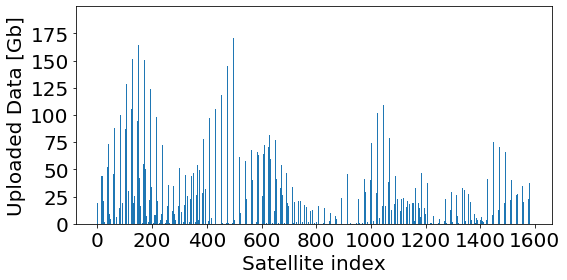

In [56]:
fontsize = 20
TRF = traffic.to_numpy().T[0]*0.1
plt.figure(figsize=(8, 4))
x = np.arange(traffic.shape[0])
plt.bar(x,TRF, width=1)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel('Satellite index',fontsize = fontsize)
plt.ylabel('Uploaded Data [Gb]',fontsize = fontsize)
plt.tight_layout()
plt.savefig('Figures/UploadedDataSEC.png',dpi=100,bbox_inches= 'tight')

In [69]:
Distances = []
for sat in Constellation:
    indexes = [link.globalid for link in sat.links.list]
    satC = cartSat[sat.globalid]
    linkC = cartSat[indexes]
    dists = np.sqrt(((linkC - satC)**2).sum(1))
    Distances.append(dists)
Distances = np.asarray(Distances)
BR = traffic.to_numpy()*2*1e9

In [109]:
Distances = []
for sat in Constellation:
    indexes = [link.globalid for link in sat.links.list][0]
    satC = cartSat[sat.globalid]
    linkC = cartSat[indexes]
    dists = np.sqrt(((linkC - satC)**2).sum())
    Distances.append(dists)
Distances = np.asarray([Distances]).T
BR = traffic.to_numpy()*8*1e9

In [123]:
h = 6.62607015e-34
c = 299792458
wavelength = 780e-9
E = h*c/wavelength
thetta = 5e-6/2
NoF = 133
nt = nr = 0.6
Dt = Dr = 0.135
Gr = (np.pi*Dt/wavelength)**2
Gt = (np.pi*Dr/wavelength)**2
Lt = np.e**(-Gt*thetta**2)
Lr = np.e**(-Gr*thetta**2)
M = 10**(5/10)
# BR = 1e9
# R = 2e6
R = Distances
Ls = (wavelength/(4*np.pi*R))**2
Pt = E*NoF*BR*M/(nt*nr*Gt*Gr*Lt*Lr*Ls)
print(Pt)


[[183.79921339]
 [678.55043921]
 [  8.56898419]
 ...
 [148.95601389]
 [860.20049698]
 [ 29.46464643]]


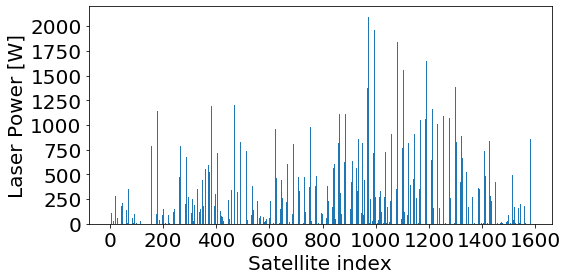

In [124]:
fontsize = 20
plt.figure(figsize=(8, 4))
x = np.arange(BR.shape[0])
plt.bar(x,Pt.T[0], width=1)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel('Satellite index',fontsize = fontsize)
plt.ylabel('Laser Power [W]',fontsize = fontsize)
plt.tight_layout()
plt.savefig('Figures/LaserPower1D.png',dpi=100)

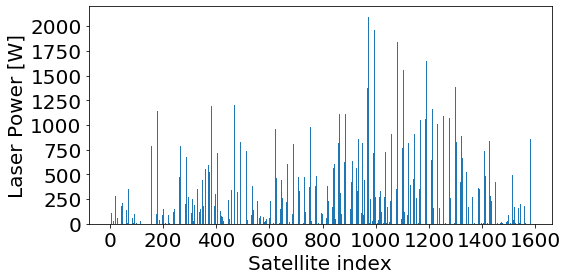

In [145]:
fontsize = 20
plt.figure(figsize=(8, 4))
x = np.arange(traffic.shape[0])
plt.bar(x,Pt.sum(1), width=1)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel('Satellite index',fontsize = fontsize)
plt.ylabel('Laser Power [W]',fontsize = fontsize)
plt.tight_layout()
plt.savefig('Figures/LaserPowerSpread.png',dpi=100)

In [281]:
trafs = []
for sat in Constellation:
    trafs.append([sat.links.forward.data,sat.links.backward.data,sat.links.left.data,sat.links.right.data])
trafs = np.asarray(trafs)*0.1*8

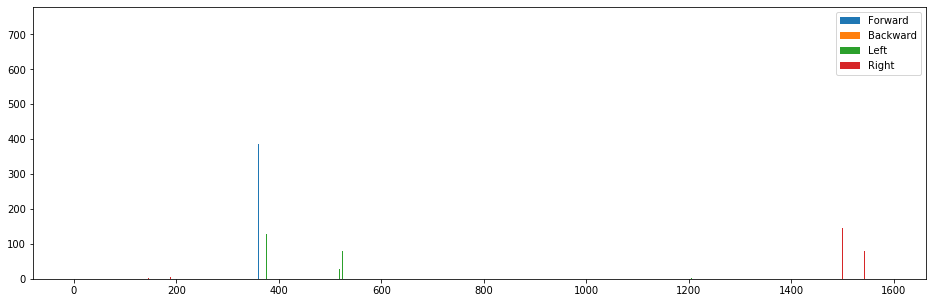

In [282]:
plt.figure(figsize=(16, 5))
width = 1
x = np.arange(traffic.shape[0])
plt.bar(x,trafs[:,0], width,label='Forward')
plt.bar(x,trafs[:,1], width,label='Backward')
plt.bar(x,trafs[:,2], width,label='Left')
plt.bar(x,trafs[:,3], width,label='Right')



plt.legend()

In [14]:
for t in range(24):
    Map = np.load(os.path.join('maps',f'TrafGrid{t}.npz'))['UTC']
    N = 0.5
    newMap = np.copy(Map)
    newMap[picMap<N] = 1
    newMap[picMap>=N] = 0
    Mask = np.asarray(np.where(newMap==0))
    np.save(f'masks/Mask{t}.npy',Mask)
    

In [50]:
for t in range(24):
    Map = np.load(os.path.join('maps',f'TrafGrid{t}.npz'))['UTC']
    N = 0.06
    newMap =  np.copy(Map)
    picMap = np.copy(Map)
    newMap[picMap<N] = 1
    newMap[picMap>=N] = 0
    picMap = ndimage.gaussian_filter(newMap, sigma=2, order=0)
    N = 0.8
    newMap[picMap<N] = 0
    newMap[picMap>=N] = 1
    Mask = np.asarray(np.where(newMap==0))
    np.save(f'masks/MaskG{t}.npy',Mask)
    

In [28]:
anal = []
for N in np.arange(0.01, 2, 0.01):
#     picMap = 10*np.log10(Map+1) 
    picMap =  Map
    newMap = np.copy(picMap)
    newMap[picMap<N] = 1
    newMap[picMap>=N] = 0
    DelT = np.sum((1-newMap)*Map)/np.sum(Map)*100
    MaskSQ = np.where(newMap==0)[0].size/Map[Map!=0].size *100
    anal.append([DelT,MaskSQ])
anal = np.asarray(anal)

In [40]:
FullMap = 0
for t in range(24):
    Map = np.load(os.path.join('maps',f'TrafGrid{t}.npz'))['UTC']
    FullMap+=Map

In [41]:
np.sum(FullMap)

1857392.1

1 73.89629483222961 5.142421387404344 3.830901


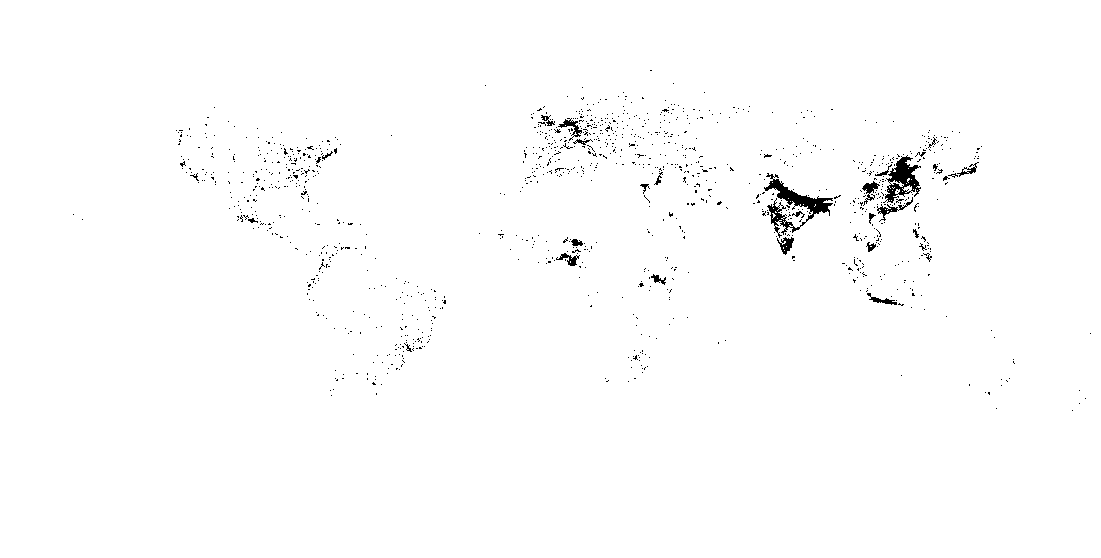

In [49]:
N = 0.03
import scipy.ndimage as ndimage
# newMap[picMap<N] = 1
# newMap[picMap>=N] = 0
newMap =  np.copy(FullMap)
picMap = np.copy(FullMap)
picMap = ndimage.gaussian_filter(FullMap, sigma=1, order=0)
N = 1
newMap[picMap<N] = 1
newMap[picMap>=N] = 0
DelT = np.sum((1-newMap)*Map)/np.sum(Map)*100
InReg = np.sum(Map)/np.sum(newMap*Map)
MaskSQ = np.where(newMap==0)[0].size/Map[Map!=0].size *100

print(N,DelT, MaskSQ,InReg)

plt.figure(figsize=(20, 10))
plt.axis('off')

# plt.imshow(newMap*Market,cmap='gray')
plt.imshow(newMap, interpolation='nearest',cmap='gray')
# plt.imshow(picMap, interpolation='nearest',cmap='gray')
plt.savefig('Mask.png',dpi = 150,bbox_inches= 'tight')


0.8 85.80433130264282 9.525383001079891 7.044409


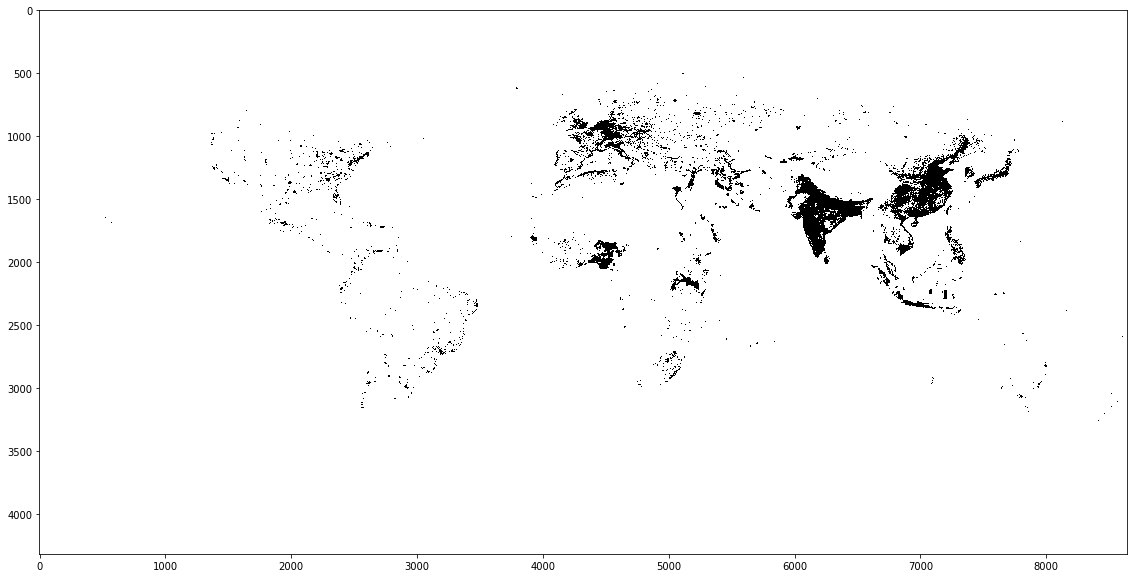

In [47]:
# picMap = 10*np.log10(Map+1) 
import scipy.ndimage as ndimage
Map = np.load(os.path.join('maps',f'TrafGrid{12}.npz'))['UTC']
newMap =  np.copy(Map)
picMap = np.copy(Map)
Market = 1
N = 0.03
newMap[picMap<N] = 1
newMap[picMap>=N] = 0
picMap = ndimage.gaussian_filter(newMap, sigma=1, order=0)
N = 0.8
newMap[picMap<N] = 0
newMap[picMap>=N] = 1
DelT = np.sum((1-newMap)*Map)/np.sum(Map)*100
InReg = np.sum(Map)/np.sum(newMap*Map*Market)
MaskSQ = np.where(newMap==0)[0].size/Map[Map!=0].size *100

print(N,DelT, MaskSQ,InReg)

plt.figure(figsize=(20, 10))

# plt.imshow(newMap*Market,cmap='gray')
plt.imshow(newMap, interpolation='nearest',cmap='gray')
# plt.imshow(picMap, interpolation='nearest',cmap='gray')
plt.savefig('Mask.png')


In [7]:
# %matplotlib notebook
import matplotlib.pyplot as plt

In [212]:
trafAl = trafs.sum(1)
free = cartSat[np.argsort(trafAl)[:500]]
trafAl = trafAl/np.max(trafAl)*500

In [213]:
hubs = result['Hub'].to_numpy()
hubs = np.unique(hubs)
hubs = cartSat[hubs]

<IPython.core.display.Javascript object>


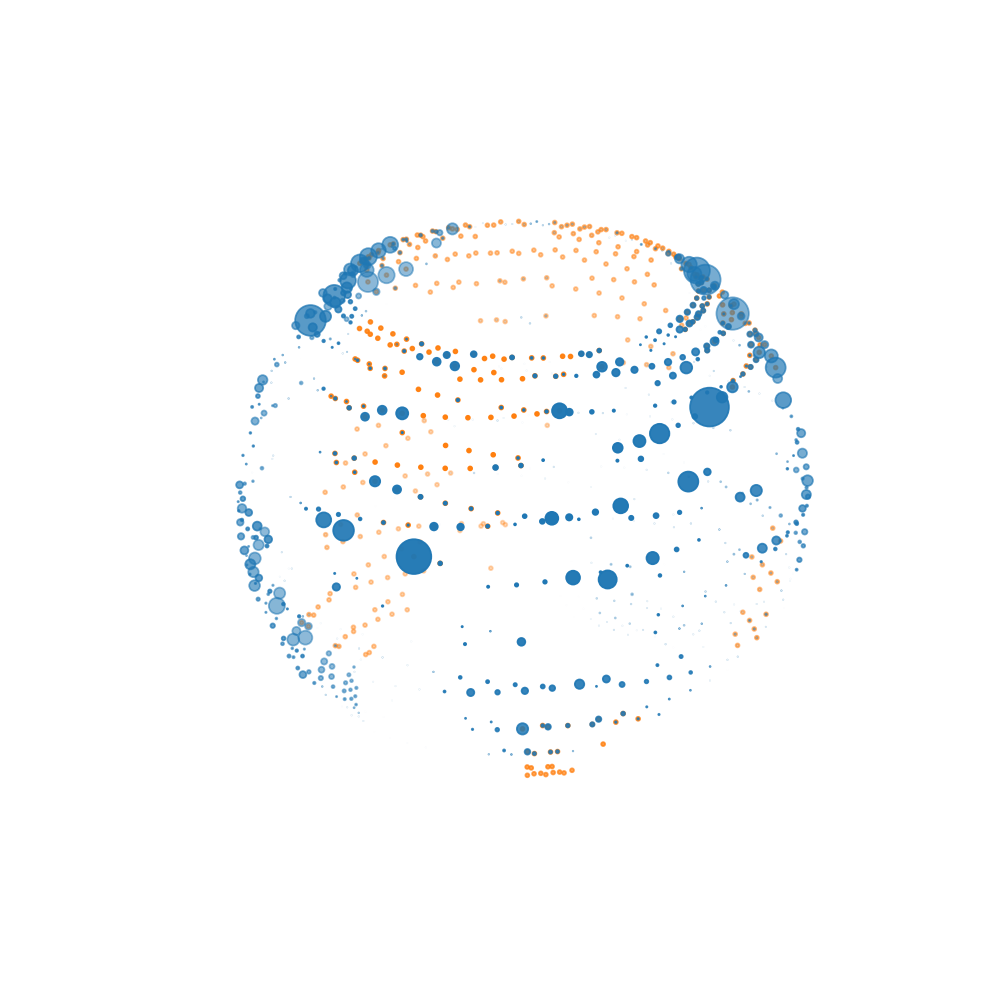

In [214]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
plt.axis('off')

ax.scatter(cartSat[:,0],cartSat[:,1],cartSat[:,2],s=trafAl)
ax.scatter(hubs[:,0],hubs[:,1],hubs[:,2],s = 5)
# ax.scatter(free[:,0],free[:,1],free[:,2],s = 5, c ='r')


R = 6378137
Sm  = 0.8
plt.ylim(-Sm*R,Sm*R)
plt.xlim(-Sm*R,Sm*R)
ax.set_zlim(-Sm*R,Sm*R)
ax.view_init(20,50)

In [248]:
TRF = []
T = 1000
for t in range(0,T):
    result = pd.read_csv(f'C:\\Users\Harkn\Desktop\BroadbandConst\outputs\PathsN\Paths_{t}.csv')
    traffic = result[['Traffic']].to_numpy().T[0]
    TRF.append(traffic)
TRF = np.asarray(TRF)

6.2607323232323235 46
2.4210858585858586 5
2.638888888888889 10
1.706439393939394 2
1.707070707070707 2
1.707070707070707 2
1.707070707070707 2
1.707070707070707 2
1.70770202020202 2
1.7108585858585859 2
1.7108585858585859 2
1.7108585858585859 2
1.7102272727272727 2
1.711489898989899 2
1.7121212121212122 2
1.7121212121212122 2
1.7121212121212122 2
1.711489898989899 2
1.711489898989899 2
1.711489898989899 2
1.7095959595959596 2
1.7089646464646464 2
1.70770202020202 2
1.70770202020202 2
1.70770202020202 2
1.70770202020202 2
1.7058080808080809 2
1.7058080808080809 2
1.706439393939394 2
1.70770202020202 2
1.7083333333333333 2
1.7089646464646464 2
1.70770202020202 2
1.7083333333333333 2
1.7089646464646464 2
1.7089646464646464 2
1.70770202020202 2
1.70770202020202 2
1.7095959595959596 2
1.7095959595959596 2
1.7083333333333333 2
1.7083333333333333 2
1.7102272727272727 2
1.7108585858585859 2
1.7121212121212122 2
1.7121212121212122 2
1.7121212121212122 2
1.711489898989899 2
1.7121212121212122 2

1.7083333333333333 2
1.70770202020202 2
1.707070707070707 2
1.706439393939394 2
1.7051767676767677 2
1.7045454545454546 2
1.7045454545454546 2
1.7051767676767677 2
1.706439393939394 2
1.706439393939394 2
1.70770202020202 2
1.70770202020202 2
1.70770202020202 2
1.707070707070707 2
1.7051767676767677 2
1.7051767676767677 2
1.7051767676767677 2
1.706439393939394 2
1.70770202020202 2
1.707070707070707 2
1.706439393939394 2
1.70770202020202 2
1.7095959595959596 2
1.7102272727272727 2
1.7108585858585859 2
1.7108585858585859 2
1.711489898989899 2
1.711489898989899 2
1.7102272727272727 2
1.7095959595959596 2
1.70770202020202 2
1.70770202020202 2
1.707070707070707 2
1.70770202020202 2
1.70770202020202 2
1.707070707070707 2
1.7058080808080809 2
1.707070707070707 2
1.706439393939394 2
1.707070707070707 2
1.7089646464646464 2
1.7083333333333333 2
1.70770202020202 2
1.7083333333333333 2
1.70770202020202 2
1.707070707070707 2
1.707070707070707 2
1.707070707070707 2
1.707070707070707 2
1.707070707070

1.7102272727272727 2
1.7095959595959596 2
1.7095959595959596 2
1.7089646464646464 2
1.7095959595959596 2
1.7102272727272727 2
1.7108585858585859 2
1.7102272727272727 2
1.7102272727272727 2
1.7102272727272727 2
1.7102272727272727 2
1.7102272727272727 2
1.7102272727272727 2
1.7108585858585859 2
1.7095959595959596 2
1.7095959595959596 2
1.7095959595959596 2
1.7089646464646464 2
1.7083333333333333 2
1.7083333333333333 2
1.7083333333333333 2
1.7089646464646464 2
1.7095959595959596 2
1.7083333333333333 2
1.707070707070707 2
1.7083333333333333 2
1.7089646464646464 2
1.7083333333333333 2
1.70770202020202 2
1.707070707070707 2
1.7058080808080809 2
1.7045454545454546 2
1.7051767676767677 2
1.7045454545454546 2
1.706439393939394 2
1.706439393939394 2
1.70770202020202 2
1.7089646464646464 2
1.7089646464646464 2
1.7095959595959596 2
1.7102272727272727 2
1.7102272727272727 2
1.711489898989899 2
1.7108585858585859 2
1.7108585858585859 2
1.7121212121212122 2
1.7127525252525253 2
1.711489898989899 2
1.

In [9]:
Trafs = []
T = 5
for sat in Constellation:
    sat.links.forward.data = 0
    sat.links.backward.data = 0
    sat.links.left.data = 0
    sat.links.right.data = 0
for t in range(2,T):
#     result = pd.read_csv(f'C:\\Users\Harkn\Desktop\BroadbandConst\outputs\PathsN\Paths_{t}.csv')
    result = pd.read_csv(f'outputs\PathsN\Paths_{t}.csv')
    Paths = [[int(n) for n in path[1:-1].split()] for path in result['Path'].values]
    for path in Paths:   
        for n in range(len(path)-1):
            master = path[n]
            slave = path[n+1]
            data = result.loc[master,'Traffic']

            if slave == Constellation[master].links.forward.to.globalid:
                Constellation[master].links.forward.data += data
            elif slave == Constellation[master].links.backward.to.globalid:
                Constellation[master].links.backward.data += data
            elif slave == Constellation[master].links.left.to.globalid:
                Constellation[master].links.left.data += data      
            elif slave == Constellation[master].links.right.to.globalid:
                Constellation[master].links.right.data += data  
    trafs = []
    for sat in Constellation:
        trafs.append([sat.links.forward.data,sat.links.backward.data,sat.links.left.data,sat.links.right.data])
    Trafs.append(trafs)
    
    for sat in Constellation:
        sat.links.forward.data = 0
        sat.links.backward.data = 0
        sat.links.left.data = 0
        sat.links.right.data = 0
    
Trafs = np.asarray(Trafs)*0.1*8

In [52]:
Load = []
for sat in Constellation:
    Data = np.array([sat.links.forward.data,sat.links.backward.data,sat.links.left.data,sat.links.right.data ])
    allData = np.sum(Data)
    Load.append(Data)
Load = np.asarray(Load)

In [56]:
# Load[Load!=Load] = 0
(Load.sum(0)/Load.sum())

array([0.13324338, 0.12915494, 0.43855851, 0.29904317])

<IPython.core.display.Javascript object>


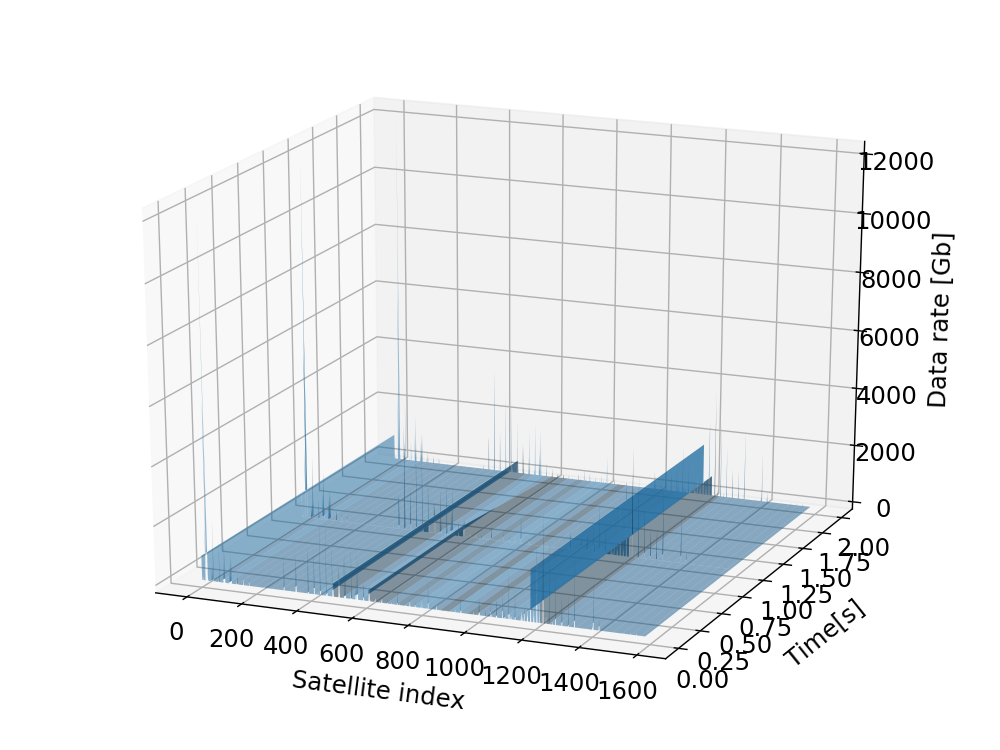

In [35]:
from mpl_toolkits.mplot3d import Axes3D
fontsize = 14

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
from matplotlib import cm

X = np.arange(Trafs.shape[1])
Y = np.arange(T-2)
X, Y = np.meshgrid(X, Y)
Fr = Trafs.T[0,:,:].T
Br = Trafs.T[1,:,:].T
Lf = Trafs.T[2,:,:].T
Rg = Trafs.T[3,:,:].T

# Plot the surface.
ax.plot_surface(X, Y, Fr,alpha=0.5)
# ax.plot_surface(X, Y, Br,alpha=0.5)
# ax.plot_surface(X, Y, Lf,alpha=0.5)
# ax.plot_surface(X, Y, Rg,alpha=0.5)




plt.xlabel('Satellite index',fontsize = fontsize)
plt.ylabel('Time[s]',fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
ax.zaxis.set_tick_params(labelsize = fontsize)
ax.yaxis.labelpad = 10
ax.xaxis.labelpad = 10
ax.zaxis.labelpad = 10
ax.set_zlabel('Data rate [Gb]',fontsize = fontsize)
ax.view_init(25,-65)
plt.tight_layout()

# plt.savefig('Figures/DataRateConst.png',dpi=100)


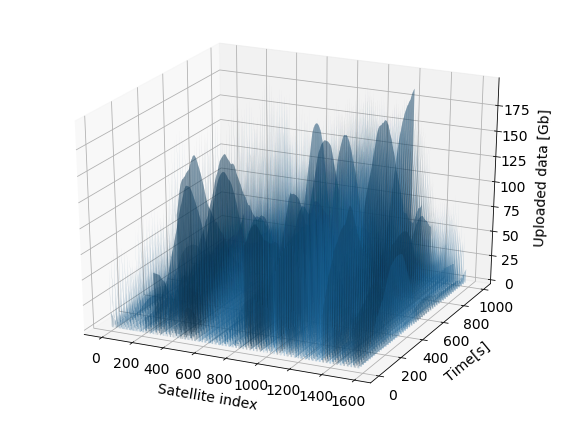

In [137]:
from mpl_toolkits.mplot3d import Axes3D
fontsize = 14

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
from matplotlib import cm

X = np.arange(traffic.shape[0])
Y = np.arange(T)
X, Y = np.meshgrid(X, Y)
Z = TRF*0.1

# Plot the surface.
surf = ax.plot_surface(X, Y, Z,alpha=0.3)

plt.xlabel('Satellite index',fontsize = fontsize)
plt.ylabel('Time[s]',fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
ax.zaxis.set_tick_params(labelsize = fontsize)
ax.yaxis.labelpad = 10
ax.xaxis.labelpad = 10
ax.zaxis.labelpad = 10
ax.set_zlabel('Uploaded data [Gb]',fontsize = fontsize)
ax.view_init(25,-65)
plt.tight_layout()

plt.savefig('Figures/UploadedDataConst.png',dpi=100)


In [170]:
Full = []
for t in range(T):
    cartSat = UpdateConstellation(Params,Constellation,t)
    Distances = []
    for sat in Constellation:
        indexes = [link.globalid for link in sat.links.list]
        satC = cartSat[sat.globalid]
        linkC = cartSat[indexes]
        dists = np.sqrt(((linkC - satC)**2).sum(1))
        Distances.append(dists)
    Full.append(Distances)
BR = TRF.T*1e9*2*0.1
Full = np.asarray(Full)

In [156]:
Full = []
for t in range(T):
    cartSat = UpdateConstellation(Params,Constellation,t)
    Distances = []
    for sat in Constellation:
        indexes = [link.globalid for link in sat.links.list][0]
        satC = cartSat[sat.globalid]
        linkC = cartSat[indexes]
        dists = np.sqrt(((linkC - satC)**2).sum())
        Distances.append(dists)
    Full.append(Distances)
BR = TRF.T*1e9*8*0.1
Full = np.asarray(Full)

In [171]:
h = 6.62607015e-34
c = 299792458
wavelength = 1064e-9
E = h*c/wavelength
thetta = 5e-6/2
NoF = 133
nt = nr = 0.6
Dt = Dr = 0.135
Gr = (np.pi*Dt/wavelength)**2
Gt = (np.pi*Dr/wavelength)**2
Lt = np.e**(-Gt*thetta**2)
Lr = np.e**(-Gr*thetta**2)
M = 10**(5/10)
# BR = 1e9
# R = 2e6
R = Full.T
Ls = (wavelength/(4*np.pi*R))**2
Pt = E*NoF*BR*M/(nt*nr*Gt*Gr*Lt*Lr*Ls)
# print(Pt)

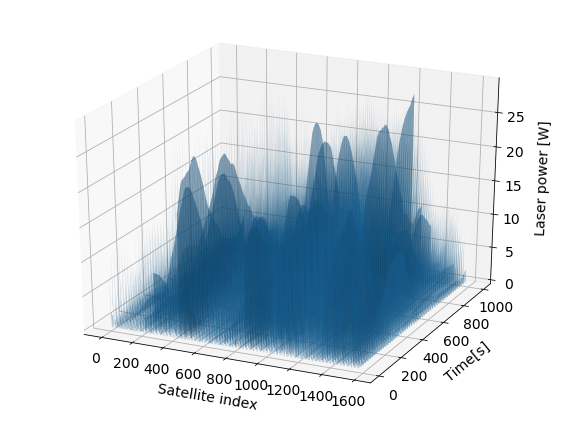

In [172]:
from mpl_toolkits.mplot3d import Axes3D
fontsize = 14

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
from matplotlib import cm

X = np.arange(Pt.sum(0).shape[0])
Y = np.arange(T)
X, Y = np.meshgrid(X, Y)
Z = Pt.sum(0).T

# Plot the surface.
surf = ax.plot_surface(X, Y, Z,alpha=0.3)

plt.xlabel('Satellite index',fontsize = fontsize)
plt.ylabel('Time[s]',fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
ax.zaxis.set_tick_params(labelsize = fontsize)
ax.set_zlabel('Laser power [W]',fontsize = fontsize)
ax.yaxis.labelpad = 10
ax.xaxis.labelpad = 10
ax.zaxis.labelpad = 10


ax.view_init(25,-65)
plt.tight_layout()

plt.savefig('Figures/LaserPowerConst.png',dpi=100)


In [174]:
Pt.sum(0).mean(), 

2.3645847484305955

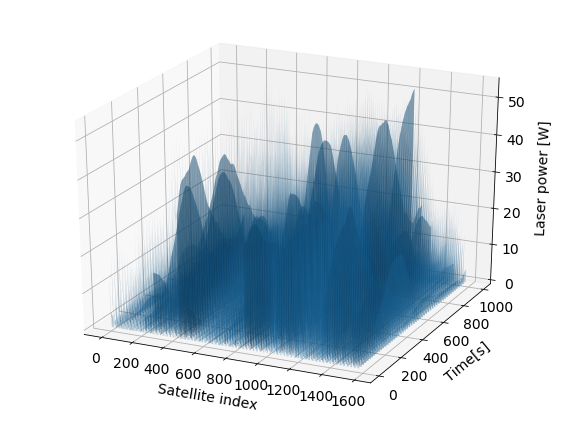

In [158]:
from mpl_toolkits.mplot3d import Axes3D
fontsize = 14

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
from matplotlib import cm

X = np.arange(Pt.shape[0])
Y = np.arange(T)
X, Y = np.meshgrid(X, Y)
Z = Pt.T

# Plot the surface.
surf = ax.plot_surface(X, Y, Z,alpha=0.3)

plt.xlabel('Satellite index',fontsize = fontsize)
plt.ylabel('Time[s]',fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
ax.zaxis.set_tick_params(labelsize = fontsize)
ax.set_zlabel('Laser power [W]',fontsize = fontsize)
ax.yaxis.labelpad = 10
ax.xaxis.labelpad = 10
ax.zaxis.labelpad = 10


ax.view_init(25,-65)
plt.tight_layout()

plt.savefig('Figures/LaserPowerConst1DIR.png',dpi=100)


In [159]:
Pt.max()

53.98615346392732